# Optimality Gap Of LLM-as-policy Reinforcement Algorithms On Gridworld Problem

- Author: Yumo Bai
- Date: Nov 3, 2023
- Email: baiym104@gmail.com

### Installing Packages

In [1]:
!pip install gym
!apt-get install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libglu1-mesa python3-opengl
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 824 kB of archives.
After this operation, 8,092 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglu1-mesa amd64 9.0.2-1 [145 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-opengl all 3.1.5+dfsg-1 [605 kB]
Fetched 824 kB in 1s (676 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../freeglut3_2.8.1-6_amd64.deb ...
Unpacking freeglut3:amd64

### Optimality Gap on the OpenAI Gym Taxi Problem

#### Import Packages

In [2]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML, Video, clear_output
import numpy as np

matplotlib.rcParams['animation.embed_limit'] = 50

#### Building the Environment

In [3]:
SIMP_ENV_NAME = 'Taxi-v3'
RENDER_MODE = 'rgb_array'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Action Space Discrete(6)
State Space Discrete(500)


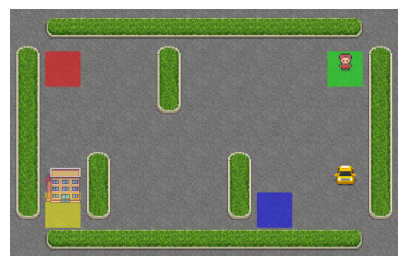

In [4]:
# Canvas for rendering the env
fig, ax = plt.subplots(figsize=(5, 5))

env = gym.make(SIMP_ENV_NAME, new_step_api=True, render_mode=RENDER_MODE)
env.reset(seed=42)
init_frame = env.render()[0]
ax.axis('off')  # Hide the axis
ax.imshow(init_frame)

# Show the number of actions and possible states in the environment
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

#### Random Action Episode

In [5]:
frames = [init_frame]  # List to hold the frames
history = []

done = False
truncated = False
while not done and not truncated:
    action = env.action_space.sample()  # Take a random action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    history.append((state, reward, done, truncated, info))

env.close()  # Don't forget to close the environment

In [6]:
def update(frame):
    ax.clear()
    ax.axis('off')  # Hide the axis
    ax.imshow(frame)

ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100, repeat=False)

ani.save('random_walk_episode.mp4', writer='ffmpeg', dpi=80)

In [7]:
from base64 import b64encode

# Load the video file and encode it as a base64 string
video_path = 'random_walk_episode.mp4'
video_file = open(video_path, "rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

# Use the HTML5 video tag to embed the video
HTML(f"""
<video width="640" height="400" controls>
  <source src="{video_url}" type="video/mp4">
</video>
""")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Optimize with Q-Learning

##### Behaviour Exploration

In [15]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Training finished.



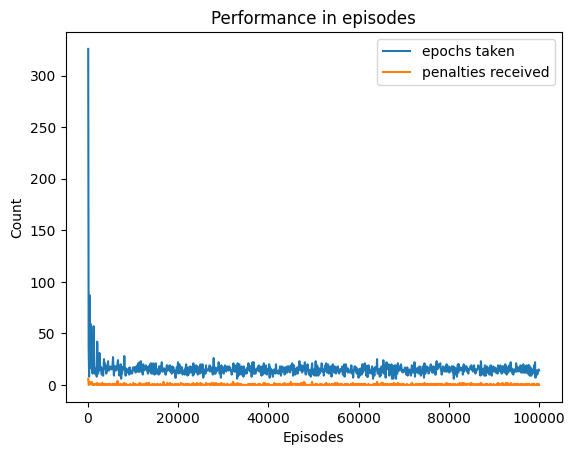

CPU times: user 4h 46min 40s, sys: 31.2 s, total: 4h 47min 11s
Wall time: 4h 49min 18s


In [16]:
%%time
"""Training the agent"""

import random

def q_learning(env, q_table, num_episodes=100000, alpha=0.1, gamma=0.6, epsilon=0.1):

  # For plotting metrics
  episodes = []
  all_epochs = []
  all_penalties = []

  for i in range(1, num_episodes+1):
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
      if random.uniform(0, 1) < epsilon:
          action = env.action_space.sample() # Explore action space
      else:
          action = np.argmax(q_table[state]) # Exploit learned values
      next_state, reward, done, truncated, info = env.step(action)

      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value
      if reward == -10:
          penalties += 1
      state = next_state
      epochs += 1

    if i % 100 == 0:
        print(f"Episode: {i}")
        clear_output(wait=True)
        episodes.append(i)
        all_epochs.append(epochs)
        all_penalties.append(penalties)

  print("Training finished.\n")

  return episodes, all_epochs, all_penalties

episodes, all_epochs, all_penalties = q_learning(env, q_table)

plt.figure()
plt.plot(episodes, all_epochs, label='epochs taken')
plt.plot(episodes, all_penalties, label='penalties received')
plt.title('Performance in episodes')
plt.xlabel('Episodes')
plt.ylabel('Count')
plt.legend()
plt.show()

np.save('q_table.npy', q_table)

from google.colab import files
files.download('q_table.npy')

In [11]:
q_table = np.load('q_table.npy')
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837064,  -2.3639511 ,  -2.41837064,  -2.3639511 ,
         -2.27325184, -11.36394725],
       [ -1.870144  ,  -1.45024008,  -1.870144  ,  -1.45024001,
         -0.7504    , -10.45023435],
       ...,
       [ -1.00897079,   0.41599966,  -0.98354117,  -1.09891256,
         -4.07163433,  -4.63241735],
       [ -2.16706467,  -2.12207113,  -2.17063126,  -2.12206944,
         -4.41436947,  -6.76108838],
       [  3.0152869 ,   0.84399347,   3.09857041,  11.        ,
         -2.54830551,  -2.93639053]])

In [12]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done, truncated = False, False

    while not done and not truncated:
        action = np.argmax(q_table[state])
        next_state, reward, done, truncated, info = env.step(action)

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.7
Average penalties per episode: 0.0


##### Q-Learning Performance

In [13]:
state = env.reset(seed=42)
init_frame = env.render()[0]
frames = [init_frame]  # List to hold the frames
history = []

done = False
truncated = False

while not done and not truncated:
    action = np.argmax(q_table[state])  # Take a random action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    history.append((state, reward, done, truncated, info))

env.close()  # Don't forget to close the environment

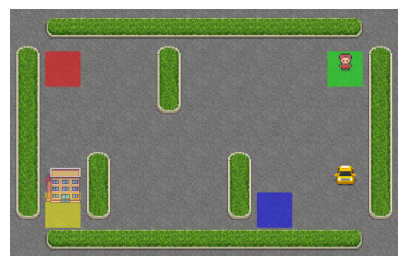

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))

def update(frame):
    ax.clear()
    ax.axis('off')  # Hide the axis
    ax.imshow(frame)

q_ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100, repeat=False)

q_ani.save('optimal_episode.mp4', writer='ffmpeg', dpi=80)

In [15]:
# Load the video file and encode it as a base64 string
video_path = 'optimal_episode.mp4'
video_file = open(video_path, "rb").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

# Use the HTML5 video tag to embed the video
HTML(f"""
<video width="640" height="400" controls>
  <source src="{video_url}" type="video/mp4">
</video>
""")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Building an LLM agent

In [16]:
!pip install scipy
!pip install tenacity
!pip install tiktoken
!pip install termcolor
!pip install openai
!pip install requests
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
   

#### Import Packages

In [17]:
import json
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
import os

from tqdm.auto import tqdm
from typing import List, Union
import zipfile

# Langchain imports
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import BaseChatPromptTemplate, ChatPromptTemplate
from langchain import SerpAPIWrapper, LLMChain
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
# LLM wrapper
from langchain.chat_models import ChatOpenAI
from langchain import OpenAI
# Conversational memory
from langchain.memory import ConversationBufferWindowMemory
# Embeddings and vectorstore
from langchain.embeddings.openai import OpenAIEmbeddings

GPT_MODEL = "gpt-4-1106-preview"

# Replace with your own OpenAI API key
os.environ['OPENAI_API_KEY'] = 'sk-XXXXXXX'

In [27]:
# helper functions for the tools

import re

# ANSI escape sequences for colors
COLORS = {
    '\x1b[34;1m': 'blue',
    '\x1b[35m': 'purple',
    '\x1b[43m': 'yellow',
    '\x1b[42m': 'green',
    '\x1b[0m': 'reset'
}
ACTION_MAP =  {'South':0, 'North':1, 'East':2, 'West':3, 'Pickup':4, 'Dropoff':5}

def get_walls(plain_text):
    plain_text = re.sub(r'\x1b\[\d+(;\d+)?m', '', rendered_text)
    walls = []
    plain_lines = plain_text.strip().split('\n')

    for row_index, line in enumerate(plain_lines[:-1]):
        for i, char in enumerate(line):
            if char == '|':
                walls.append((row_index, i))
    return walls


# Function to parse the ANSI-rendered text
def parse_ansi_rendered_text(rendered_text):
    # Split the rendered text into lines
    lines = rendered_text.strip().split('\n')

    # Initialize variables
    last_action = lines[-1].strip('( )') if lines[-1].strip('( )') in ACTION_MAP else None
    taxi_row, taxi_col = None, None
    passenger_location = None
    destination = None
    passenger_in_taxi = False

    # Iterate over the lines to find the taxi, passenger, and destination
    for row_index, line in enumerate(lines[:-1]):
        # Split the line into cells based on the grid separators
        cells = re.split(r'\||:', line)
        for col_index, cell in enumerate(cells):
            if '\x1b[42m' in cell:  # Check for green background indicating the passenger is in the taxi
                passenger_in_taxi = True
                taxi_row, taxi_col = row_index, col_index*2-1
            elif '\x1b[43m' in cell:  # Check for yellow background indicating the taxi
                taxi_row, taxi_col = row_index, col_index*2-1
            if '\x1b[34;1m' in cell:  # Check for blue text indicating the passenger
                passenger_location = row_index, col_index*2-1
                # passenger_location = re.sub(r'\x1b\[\d+(;\d+)?m', '', cell).strip()
            if '\x1b[35m' in cell:  # Check for purple text indicating the destination
                destination = row_index, col_index*2-1
                # destination = re.sub(r'\x1b\[\d+(;\d+)?m', '', cell).strip()

    # Remove the ANSI escape sequences for colors
    plain_text = re.sub(r'\x1b\[\d+(;\d+)?m', '', rendered_text)
    walls = get_walls(plain_text)

    return {
        'last_action' : last_action,
        'taxi_location': (taxi_row, taxi_col),
        'passenger_location': passenger_location,
        'destination': destination,
        'passenger_in_taxi': passenger_in_taxi,
        'wall_locations': walls
    }

# Function to generate a textual description from the parsed information
def generate_textual_description(parsed_info):
    description = ""
    if parsed_info['last_action']:
        description += f"Last action taken is {parsed_info['last_action']}. "
    description += f"The taxi is currently at {parsed_info['taxi_location']}. "
    if parsed_info['passenger_in_taxi']:
        description += "The passenger is in the taxi. "
    else:
        description += f"The passenger is waiting at {parsed_info['passenger_location']}. "
    if parsed_info['passenger_location'] == parsed_info['destination']:
        description += f"The passenger has successfully reached the destination at {parsed_info['passenger_location']}. "
    else:
        description += f"The destination is at {parsed_info['destination']}.\n"

    if parsed_info['wall_locations']:
        description += f'There are walls at {parsed_info["wall_locations"]}. \n'

    return description

# Example usage
rendered_text = '+---------+\n|R: | : :\x1b[34;1mG\x1b[0m|\n| : | : : |\n| : : : : |\n| | : | :\x1b[43m \x1b[0m|\n|\x1b[35mY\x1b[0m| : |B: |\n+---------+\n\n'
parsed_info = parse_ansi_rendered_text(rendered_text)
textual_description = generate_textual_description(parsed_info)

print(parsed_info)
print(textual_description)

{'last_action': None, 'taxi_location': (4, 9), 'passenger_location': (1, 9), 'destination': (5, 1), 'passenger_in_taxi': False, 'wall_locations': [(1, 0), (1, 4), (1, 10), (2, 0), (2, 4), (2, 10), (3, 0), (3, 10), (4, 0), (4, 2), (4, 6), (4, 10), (5, 0), (5, 2), (5, 6), (5, 10)]}
The taxi is currently at (4, 9). The passenger is waiting at (1, 9). The destination is at (5, 1).
There are walls at [(1, 0), (1, 4), (1, 10), (2, 0), (2, 4), (2, 10), (3, 0), (3, 10), (4, 0), (4, 2), (4, 6), (4, 10), (5, 0), (5, 2), (5, 6), (5, 10)]. 



In [28]:
def take_action_step(action):
    '''Make one action step in the environment. Action can be one of South, North, East, West, Pickup, Dropoff'''
    action = ACTION_MAP[action.strip('\n')]
    env.step(action)

    rendered_text = env.render()[0]
    print('\n'+rendered_text)
    parsed_info = parse_ansi_rendered_text(rendered_text)
    textual_description = generate_textual_description(parsed_info)

    return textual_description

In [29]:
# Define a list of tools
from langchain.tools import StructuredTool

tool = StructuredTool.from_function(take_action_step)

In [49]:
# Set up the prompt with input variables for tools, user input and a scratchpad for the model to record its workings
template = """You will be controlling a taxi to pick up a passenger and drop him off at the destination location. The task is going to be performed in a gridworld with specifications as follows:
- The gridworld is constructed with the following symbols: ["|", "-", ":", " ", "R", "G", "Y", "B"]:
  --`|` and `-` represent a wall that the taxi cannot pass through, East-West or North-South, respectively.
  -- `:` represent a boundary that a taxi can pass through.
  -- `R, G, Y, B` represents colored regions that can be where the passenger is starting at or going to.
  -- ` ` represent space that the taxi can park at, the taxi can also go onto the colored regions.
- There are six actions in the action space ["South","North","East","West", "Pickup", 'Dropoff'], first four moves the taxi for one unit to the corresponding directions (down, up, right, left), last two picks up and drops off the passenger.
  -- The passenger can only be picked up or dropped off at one of the colored regions.
  -- The taxi's position will be represented as (row, col). `row` and `col` are 1-indexed.
  -- "South","North" changes the taxi's position to (row+1, col), (row-1, col).
  -- If there is not a wall blocking, "East","West" moves the taxi first to the (row, col +/- 1) suppose where the open space is then (row, col +/- 2) to the actual grid it is heading.
  -- Attempting moving the taxi onto or jumping over a wall would not change its position and should be avoided.
  -- "Pickup" and "Dropoff" should only be performed when taxi's position equals to the desired position.
- The positions of walls `|` are encoded in as location (row, col). The taxi cannot move onto or jump over the wall.
  -- i.e The taxi cannot go from (5,7) to (5,5) given there is a wall at (5,6)

The gridworld is constructed as follows:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Plan the taxi's movements ahead and carefully to avoid the walls. Pickup the passenger and drop him off at the destination.

TOOLS:
------
You have access to the following tools:

{tools}

To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
```
... (this Thought/Action/Action Input/Observation can repeat N times)

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: The objective has been achieved. i.e `passenger_location` == `destination_location`
Final Answer: [The list of action steps taken.]
```

Begin!

Task: {input}
{agent_scratchpad}"""

In [50]:
# Set up a prompt template
class CustomPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)

        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "

        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts

        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]

prompt = CustomPromptTemplate(
    template=template,
    tools=[tool],
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

In [51]:
class CustomOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:

        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].strip(' []').split(', ')},
                log=llm_output,
            )

        # Parse out the action and action input
        regex = r"Action: (.*?)[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)

        # If it can't parse the output it raises an error
        # You can add your own logic here to handle errors in a different way i.e. pass to a human, give a canned response
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)

        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)

output_parser = CustomOutputParser()

In [52]:
env = gym.make('Taxi-v3', new_step_api=True, render_mode='ansi')
state = env.reset(seed=42)
rendered_text = env.render()[0]

parsed_info = parse_ansi_rendered_text(rendered_text)
textual_description = generate_textual_description(parsed_info)

In [53]:
# Initiate our GPT instance
llm = ChatOpenAI(model=GPT_MODEL, temperature=0, api_key=os.environ['OPENAI_API_KEY'])

# LLM chain consisting of the LLM and a prompt
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Using tools, the LLM chain and output_parser to make an agent
tool_names = [tool.name]

agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=output_parser,
    # We use "Observation" as our stop sequence so it will stop when it receives Tool output
    # If you change your prompt template you'll need to adjust this as well
    stop=["\nObservation:"],
    allowed_tools=tool_names,
    max_execution_time=120,
    max_iterations=60
)

# Initiate the agent that will respond to our queries
# Set verbose=True to share the CoT reasoning the LLM goes through
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=[tool], verbose=True)
actions = agent_executor.run(textual_description)
env.close()



> Entering new AgentExecutor chain...
Thought: I need to plan a route to pick up the passenger at (1, 9) and then drop them off at (5, 1). The taxi is currently at (4, 9). The first step is to navigate to the passenger's location without hitting any walls.

Action: take_action_step
Action Input: North
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Observation:Last action taken is North. The taxi is currently at (3, 9). The passenger is waiting at (1, 9). The destination is at (5, 1).
There are walls at [(1, 0), (1, 4), (1, 10), (2, 0), (2, 4), (2, 10), (3, 0), (3, 10), (4, 0), (4, 2), (4, 6), (4, 10), (5, 0), (5, 2), (5, 6), (5, 10)]. 

The taxi is now at (3, 9). To reach the passenger at (1, 9), I need to continue moving North without hitting any walls.

Action: take_action_step
Action Input: North
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Observation:Last action taken is North. 

'[North, North, North, Pickup, South, West, West, South, West, West, South, South, Dropoff]'

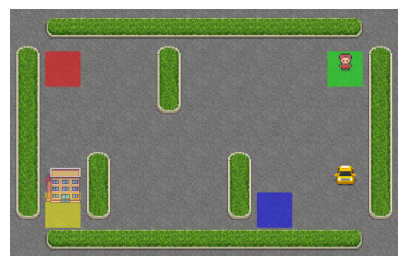

In [66]:
# Canvas for rendering the env
fig, ax = plt.subplots(figsize=(5, 5))

env = gym.make(SIMP_ENV_NAME, new_step_api=True, render_mode=RENDER_MODE)
env.reset(seed=42)
init_frame = env.render()[0]
ax.axis('off')  # Hide the axis
ax.imshow(init_frame)

frames = [init_frame]  # List to hold the frames

for a in actions:
    action = ACTION_MAP[a]
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame

env.close()  # Don't forget to close the environment

In [67]:
ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100, repeat=False)

ani.save('GPT4_ReAct_episode.mp4', writer='ffmpeg', dpi=80)